##  Simulation of a plastic, balanced network 
We simulate a network as defined in Akil et al. 2021. Plasticity may be on any synapse type (ee,ei,ie,ii).
Excitatory synapses can undergo weight-dependent Hebbian or Kohonen's STDP, while inhibitory synapses can experience iSTDP.

Code published: March 2021

Author: Alan E. Akil

Preprint: https://www.biorxiv.org/content/10.1101/2020.04.26.061515v1

In [242]:
# Import a few necessary packages.
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import seaborn as sns
import time

## Outline

We will first define all parameters relevant to the simulation. Then we will create an object called "plasticNeuralNetwork" that will simulate a plastic, balanced neural network according to the defined parameters. 

Define: network size, probabilities of connection, timescale of correlation, and mean connection strengths.

In [243]:
# Number of neurons in each population
N = int(5000)
Ne = int(0.8*N)
Ni = int(0.2*N)
# Number of neurons in ffwd layer
Nx = int(0.2*N)

# Recurrent net connection probabilities
P=np.array([[0.1, 0.1], [0.1, 0.1]])
# Ffwd connection probs
Px=np.array([[.1],[.1]])

# Timescale of correlation
taujitter=5
# Mean connection strengths between each cell type pair
Jm=np.array([[1, -150],[112.5, -250]])/np.sqrt(N)
Jxm=np.array([[180],[135]])/np.sqrt(N)

Define total time of simulation, discretization, rate of ffwd spikes, mean--field matrices, synaptic timescales, and correlation between ffwd spike trains.

In [244]:
# Total_time (in ms) for sim
T=500000

# Total_time discretization
dt=.1

# Proportions
qe=Ne/N
qi=Ni/N
qf=Nx/N

# FFwd spike train rate (in kHz)
rx=10/1000

# Number of Total_time bins
Nt=round(T/dt)
total_time=np.arange(dt,T+dt,dt)

# Extra stimulus: Istim is a Total_time-dependent stimulus
# it is delivered to all neurons with weights given by JIstim.
# Specifically, the stimulus to neuron j at Total_time index i is:
# Istim(i)*JIstim(j)
Istim=np.zeros(len(total_time)) 
Istim[total_time>T/2]=1
jestim=0
jistim=0
Jstim = np.sqrt(N) * np.hstack(( np.transpose( np.array(jestim * np.ones((Ne,1))) ), 
                                np.transpose( np.array(jistim * np.ones((Ni,1))) ) )) 

# Build mean field matrices
Q=[[qe, qi],[qe, qi]];
Qf=[[qf],[qf]];
W=P*(Jm*np.sqrt(N))*Q;
Wx=Px*(Jxm*np.sqrt(N))*Qf;

# Synaptic timescales
taux=10;
taue=8;
taui=4;

# Generate FFwd spike trains
c=0.1

# Maximum number of spikes for all neurons
# in simulation. Make it 50Hz across all neurons
# If there are more spikes, the simulation will terminate
maxns=round(.05*N*T); # was 0.05.


Define neuron parameters and plasticity parameters.

In [245]:
# Neuron parameters
Cm=1
gL=1/15
EL=-72
Vth=-50
Vre=-75
DeltaT=1
VT=-55

# Plasticity parameters
tauSTDP=200 # ms

#EE hebb
Jmax_ee = 30/np.sqrt(N)
eta_ee_hebb= 0/10**3 # Learning rate 

#EE kohonen
beta = 2/np.sqrt(N)
eta_ee_koh= 1/10**2 # Learning rate 

#IE hebb
Jmax_ie_hebb = 125/np.sqrt(N)
eta_ie_hebb= 0/10**3 # Learning rate 

#IE homeo
Jnorm_ie = 200/np.sqrt(N)
eta_ie_homeo = 0/10**3 /Jnorm_ie # Learning rate 
rho_ie=0.020 # Target rate 20Hz
alpha_ie=2*rho_ie*tauSTDP;

#EI homeo
Jnorm_ei = -200/np.sqrt(N)
eta_ei=1/10**3 /Jnorm_ei # Learning rate 
rho_ei=0.010 # Target rate 10Hz
alpha_ei=2*rho_ei*tauSTDP;

#II
Jnorm_ii = -300/np.sqrt(N)
eta_ii= 0/10**3 /Jnorm_ii # Learning rate 
rho_ii=0.020 # Target rate 20Hz
alpha_ii=2*rho_ii*tauSTDP;

Define a few variables for recording inputs, weights, etc.

In [246]:
# Indices of neurons to record currents, voltages
nrecord0=100 # Number to record from each population
Irecord=np.array([[random.sample(list(np.arange(0,Ne)),nrecord0) , random.sample(list(np.arange(Ne,N)),nrecord0) ]])
Irecord = Irecord[0,1]
numrecord=len(Irecord) # total number to record

# Number of time bins to average over when recording
nBinsRecord=10
dtRecord=nBinsRecord*dt
timeRecord=np.arange(dtRecord,T+dtRecord,dtRecord)
Ntrec=len(timeRecord)

Define the actual neural network as an object. 
It contains functions that define connectivity, generate poisson input, and employ the actual simulation.

In [247]:
class plasticNeuralNetwork:
    def __init__(self, N,Ne,Ni,Nx,P,Px,taujitter,Jm,Jxm,T,dt,rx,Nt,total_time,taue,taui,taux,
                c,Cm,gL,EL,Vth,Vre,DeltaT,VT,maxns,tauSTDP,Jmax_ee,eta_ee_hebb,eta_ee_koh,beta,eta_ie_hebb
                 ,Jmax_ie_hebb,eta_ie,alpha_ie,
                alpha_ei,eta_ei,alpha_ii,eta_ii,dtRecord,timeRecord,Ntrec,numrecord):
        
        self.N = N; self.Ne = Ne; self.Ni = Ni; self.Nx = Nx
        self.P = P; self.Px = Px; self.taujitter = taujitter
        self.Jm = Jm; self.Jxm = Jxm; self.T = T; self.dt = dt; self.rx = rx;
        self.Nt = Nt; self.total_time = total_time;
        self.taue = taue; self.taui = taui; self.taux = taux
        self.c = c; self.maxns = maxns;
        self.Cm = Cm; self.gL = gL; self.EL = EL; self.Vth = Vth; self.Vre = Vre; self.DeltaT = DeltaT; self.VT = VT
        self.tauSTDP = tauSTDP; self.Jmax_ee = Jmax_ee; self.eta_ee_hebb = eta_ee_hebb; self.Jmax_ie_hebb = Jmax_ie_hebb;
        self.eta_ie_hebb = eta_ie_hebb; self.eta_ie_homeo = eta_ie_homeo; self.alpha_ie = alpha_ie;
        self.eta_ie = eta_ie; self.eta_ei = eta_ei; self.alpha_ei = alpha_ei; self.eta_ii = eta_ii;
        self.alpha_ii = alpha_ii; self.eta_ee_koh = eta_ee_koh; self.beta = beta;
        self.nBinsRecord = nBinsRecord; self.dtRecord = dtRecord;
        self.timeRecord = timeRecord; self.Ntrec = Ntrec; 
        self.numrecord = numrecord; 
        
    def connectivity(self):
        # Define connectivity
        self.J = np.vstack(( np.hstack((np.array(self.Jm[0,0] * np.random.binomial(1,self.P[0,0],(self.Ne,self.Ne))), 
              np.array(self.Jm[0,1] * np.random.binomial(1,self.P[0,1],(self.Ne,self.Ni))))), 
              np.hstack((np.array(self.Jm[1,0] * np.random.binomial(1,self.P[1,0],(self.Ni,self.Ne))), 
              np.array(self.Jm[1,1] * np.random.binomial(1,self.P[1,1],(self.Ni,self.Ni))))) ))
 
        self.Jx = np.vstack(( np.array(self.Jxm[0,0] * np.random.binomial(1,self.Px[0,0],(self.Ne,self.Nx))), 
               np.array(self.Jxm[1,0] * np.random.binomial(1,self.P[1,0],(self.Ni,self.Nx))) ))
        
        # Define variables to record changes in weights.
        # Synaptic weights EE to record. 
        # The first row of Jrecord is the postsynaptic indices
        # The second row is the presynaptic indices
        nJrecord0=1000 # Number to record
        IIJJ_rec=np.argwhere(self.J[0:self.Ne,0:self.Ne]) # Find non-zero I to E weights
        II = IIJJ_rec[:,0]
        JJ = IIJJ_rec[:,1]
        III=random.sample(list(II),nJrecord0) # Choose some at random to record
        II=II[III]
        JJ=JJ[III]
        self.Jrecord_ee=np.array([II, JJ]) # Record these
        self.numrecordJ_ee= len(JJ)

        # Synaptic weights IE to record. 
        # The first row of Jrecord is the postsynaptic indices
        # The second row is the presynaptic indices
        nJrecord0=1000 # Number to record
        IIJJ_rec=np.argwhere(self.J[self.Ne+1:self.N,0:self.Ne]) # Find non-zero I to E weights
        II = IIJJ_rec[:,0]
        JJ = IIJJ_rec[:,1]
        III=random.sample(list(II),nJrecord0) # Choose some at random to record
        II=II[III]
        JJ=JJ[III]
        self.Jrecord_ie=np.array([II+self.Ne, JJ]) # Record these
        self.numrecordJ_ie= len(JJ)

        # Synaptic weights EI to record. 
        # The first row of Jrecord is the postsynaptic indices
        # The second row is the presynaptic indices
        nJrecord0=1000 # Number to record
        IIJJ_rec=np.argwhere(self.J[0:self.Ne,self.Ne+1:self.N]) # Find non-zero I to E weights
        II = IIJJ_rec[:,0]
        JJ = IIJJ_rec[:,1]
        III=random.sample(list(II),nJrecord0) # Choose some at random to record
        II=II[III]
        JJ=JJ[III]
        self.Jrecord_ei=np.array([II, JJ+self.Ne]) # Record these
        self.numrecordJ_ei= len(JJ)
        
        # Synaptic weights II to record. 
        # The first row of Jrecord is the postsynaptic indices
        # The second row is the presynaptic indices
        nJrecord0=1000 # Number to record
        IIJJ_rec=np.argwhere(self.J[self.Ne+1:self.N,self.Ne+1:self.N]) # Find non-zero I to E weights
        II = IIJJ_rec[:,0]
        JJ = IIJJ_rec[:,1]
        III=random.sample(list(II),nJrecord0) # Choose some at random to record
        II=II[III]
        JJ=JJ[III]
        self.Jrecord_ii=np.array([II+self.Ne, JJ+self.Ne]) # Record these
        self.numrecordJ_ii= len(JJ)
    
    def ffwd_spikes(self):
        if(self.c<1e-5): # If uncorrelated
            nspikeX=np.random.poisson(self.Nx*self.rx*self.T)
            st=np.random.uniform(0,1,(1,nspikeX))*self.T
            sx=np.zeros((2,len(st[0])))
            sx[0,:]=np.sort(st)[0]
            sx[1,:]=np.random.randint(1,Nx,(1,len(st[0]))) # neuron indices
        else: # If correlated
            rm=self.rx/self.c # Firing rate of mother process
            nstm=np.random.poisson(rm*self.T) # Number of mother spikes
            stm=np.random.uniform(0,1,(nstm,1))*self.T # spike times of mother process    
            maxnsx=int(self.T*self.rx*self.Nx*1.2) # Max num spikes
            sx=np.zeros((2,maxnsx))
            ns=0
            for j in np.arange(1,self.Nx,1):  # For each ffwd spike train
                ns0=np.random.binomial(nstm,self.c) # Number of spikes for this spike train
                st=random.sample(list(stm[:,0]),ns0) # Sample spike times randomly
                st=st+self.taujitter*np.random.normal(0,1,size=len(st)) # jitter spike times
                st=st[(st>0) & (st<self.T)] # Get rid of out-of-bounds times
                ns0=len(st) # Re-compute spike count
                sx[0,ns+1:ns+ns0+1]=st # Set the spike times and indices        
                sx[1,ns+1:ns+ns0+1]=j
                ns=ns+ns0

            # Get rid of padded zeros
            sx = sx[:,sx[0,:]>0]

            # Sort by spike time
            I = np.argsort(sx[0,:])
            self.sx = sx[:,I]
            self.nspikeX=len(sx[0,:]);
    
#     @jit(nopython=False)
    def simulate(self):
        # Initialize some variables
        # Random initial voltages
        V0=np.random.uniform(0,1,(1,self.N))*(self.VT-self.Vre)+self.Vre; V=V0
        Ie=np.zeros((1,self.N)); Ii=np.zeros((1,self.N)); Ix=np.zeros((1,self.N))
        x=np.zeros((1,self.N))
        IeRec=np.zeros((self.numrecord,self.Ntrec));IiRec=np.zeros((self.numrecord,self.Ntrec)); 
        IxRec=np.zeros((self.numrecord,self.Ntrec))
        # VRec=np.zeros((numrecord,Ntrec))
        JRec_ee=np.zeros((self.numrecordJ_ee,self.Ntrec)); JRec_ie=np.zeros((self.numrecordJ_ie,self.Ntrec))
        JRec_ei=np.zeros((self.numrecordJ_ei,self.Ntrec)); JRec_ii=np.zeros((self.numrecordJ_ii,self.Ntrec))
        iFspike=0; s=np.zeros((2,maxns)); nspike=0; TooManySpikes=0

        # Start the simulation.
        start_time = time.time()

        for i in range(len(self.total_time)):
            # Propagate ffwd spikes
            while( (self.sx[0,iFspike]<=self.total_time[i]) & (iFspike<self.nspikeX-1) ):
                jpre=int(self.sx[1,iFspike])
                Ix=Ix+self.Jx[:,jpre]/taux
                iFspike+=1

            # Euler update to V
            V+=(self.dt/self.Cm)*(Istim[i]*Jstim+Ie+Ii+Ix+self.gL*(self.EL-V)+self.gL*self.DeltaT*np.exp((V-self.VT)/self.DeltaT))

            # Find which neurons spiked
            Ispike=np.argwhere(V>=self.Vth)[:,1]  

            # If there are spikes
            if(len(Ispike)!=0):

                # Store spike times and neuron indices
                if(nspike+len(Ispike)<=self.maxns):
                    s[0,nspike+1:nspike+len(Ispike)+1]=self.total_time[i]
                    s[1,nspike+1:nspike+len(Ispike)+1]=Ispike
                else:
                    TooManySpikes=1
                    break        

                # Update synaptic currents
                Ie+=np.sum(self.J[:,Ispike[Ispike<=self.Ne]],1)/self.taue
                Ii+=np.sum(self.
                           J[:,Ispike[Ispike>self.Ne]],1)/self.taui            

                # If there is EE Hebbian plasticity
                if(self.eta_ee_hebb!=0):
                    # Update synaptic weights according to plasticity rules
                    # E to E after a pre spike 
                    self.J[0:self.Ne,Ispike[Ispike<=self.Ne]]-=np.tile(
                        self.eta_ee_hebb*(x[0,0:self.Ne]),(np.count_nonzero(Ispike<=self.Ne),1)).transpose() * (self.J[0:self.Ne,Ispike[Ispike<=self.Ne]])
                    # E to E after a post spike
                    self.J[Ispike[Ispike<self.Ne],0:self.Ne]+=np.tile(
                        self.eta_ee_hebb*x[0,0:self.Ne].transpose(),(np.count_nonzero(Ispike<self.Ne),1) ) * Jmax_ee * (self.J[Ispike[Ispike<self.Ne],0:self.Ne]!=0)
                
                # If there is EE Kohonen plasticity
                if(self.eta_ee_koh!=0):
                    # Update synaptic weights according to plasticity rules
                    # E to E after a pre spike 
                    self.J[0:self.Ne,Ispike[Ispike<=self.Ne]]+=np.tile(self.beta*
                        self.eta_ee_koh*(x[0,0:self.Ne]),(np.count_nonzero(Ispike<=self.Ne),1)).transpose() * (self.J[0:self.Ne,Ispike[Ispike<=self.Ne]]!=0)
                    # E to E after a post spike
                    self.J[Ispike[Ispike<self.Ne],0:self.Ne]-=self.eta_ee_koh*self.J[Ispike[Ispike<self.Ne],0:self.Ne]

                # If there is IE *Homeo* plasticity
                if(self.eta_ie_homeo!=0):
                    # Update synaptic weights according to plasticity rules
                    # E to I after a pre spike 
                    self.J[self.Ne:self.N,Ispike[Ispike<=self.Ne]]-=np.tile(
                        self.eta_ie_homeo*(x[0,self.Ne:self.N]-self.alpha_ie),(np.count_nonzero(Ispike<=self.Ne),1)).transpose() * (self.J[self.Ne:self.N,Ispike[Ispike<=self.Ne]])
                    # E to I after a post spike
                    self.J[Ispike[Ispike>self.Ne],0:self.Ne]-=np.tile(
                        self.eta_ie_homeo*x[0,0:self.Ne].transpose(),(np.count_nonzero(Ispike>self.Ne),1) ) * (self.J[Ispike[Ispike>self.Ne],0:self.Ne])
                
                # If there is IE *Hebbian* plasticity
                if(self.eta_ie_hebb!=0):
                    # Update synaptic weights according to plasticity rules
                    # E to I after a pre spike 
                    self.J[self.Ne:self.N,Ispike[Ispike<=self.Ne]]-=np.tile(
                        self.eta_ie_hebb*(x[0,self.Ne:self.N]),(np.count_nonzero(Ispike<=self.Ne),1)).transpose() * (self.J[self.Ne:self.N,Ispike[Ispike<=self.Ne]]!=0)
                    # E to I after a post spike
                    self.J[Ispike[Ispike>self.Ne],0:self.Ne]+=np.tile(
                        self.eta_ie_hebb*x[0,0:self.Ne].transpose(),(np.count_nonzero(Ispike>self.Ne),1) ) *Jmax_ie_hebb* (self.J[Ispike[Ispike>self.Ne],0:self.Ne]!=0)
                
                # If there is EI plasticity
                if(self.eta_ei!=0):
                    # Update synaptic weights according to plasticity rules
                    # I to E after an I spike 
                    self.J[0:self.Ne,Ispike[Ispike>=self.Ne]]-=np.tile(
                        self.eta_ei*(x[0,0:self.Ne]-self.alpha_ei),(np.count_nonzero(Ispike>=self.Ne),1)).transpose() * (self.J[0:self.Ne,Ispike[Ispike>=self.Ne]])
                    # I to E after an E spike
                    self.J[Ispike[Ispike<self.Ne],self.Ne:self.N]-=np.tile(
                        self.eta_ei*x[0,self.Ne:self.N].transpose(),(np.count_nonzero(Ispike<self.Ne),1) ) * (self.J[Ispike[Ispike<self.Ne],self.Ne:self.N])                    
                
                # If there is II plasticity
                if(self.eta_ii!=0):
                    # Update synaptic weights according to plasticity rules
                    # I to E after an I spike 
                    self.J[self.Ne:self.N,Ispike[Ispike>=self.Ne]]-=np.tile(
                        self.eta_ii*(x[0,self.Ne:self.N]-self.alpha_ii),(np.count_nonzero(Ispike>=self.Ne),1)).transpose() * (self.J[self.Ne:self.N,Ispike[Ispike>=self.Ne]])
                    # I to E after an E spike
                    self.J[Ispike[Ispike>self.Ne],self.Ne:self.N]-=np.tile(
                        self.eta_ii*x[0,self.Ne:self.N].transpose(),(np.count_nonzero(Ispike>self.Ne),1) ) * (self.J[Ispike[Ispike>self.Ne],self.Ne:self.N])

                # Update rate estimates for plasticity rules
                x[0,Ispike]+=1

                # Update cumulative number of spikes
                nspike+=len(Ispike)

            # Euler update to synaptic currents
            Ie-=self.dt*Ie/self.taue; Ii-=self.dt*Ii/self.taui; Ix-=self.dt*Ix/self.taux

            # Update time-dependent firing rates for plasticity
            x[0:self.Ne]-=self.dt*x[0:self.Ne]/self.tauSTDP; x[self.Ne:self.N]-=self.dt*x[self.Ne:self.N]/self.tauSTDP

            # This makes plots of V(t) look better.
            # All action potentials reach Vth exactly. 
            # This has no real effect on the network sims
            V[0,Ispike]=self.Vth

            # Store recorded variables
            ii=math.floor((i-1)/nBinsRecord) 
            IeRec[:,ii]+=Ie[0,Irecord]; IiRec[:,ii]+=Ii[0,Irecord]; IxRec[:,ii]+=Ix[0,Irecord]
        #     VRec[:,ii]+=V[Irecord]
            JRec_ee[:,ii] += self.J[self.Jrecord_ee[0,:],self.Jrecord_ee[1,:]]; 
            JRec_ie[:,ii] += self.J[self.Jrecord_ie[0,:],self.Jrecord_ie[1,:]]
            JRec_ei[:,ii] += self.J[self.Jrecord_ei[0,:],self.Jrecord_ei[1,:]]; 
            JRec_ii[:,ii] += self.J[self.Jrecord_ii[0,:],self.Jrecord_ii[1,:]]

            # Reset mem pot.
            V[0,Ispike]=self.Vre

        elapsed_time = time.time()-start_time
        print('Time for simulation: ', elapsed_time/60, 'minutes')

        IeRec=IeRec/self.nBinsRecord # Normalize recorded variables by # bins
        IiRec=IiRec/self.nBinsRecord
        IxRec=IxRec/self.nBinsRecord
        # VRec=VRec/nBinsRecord;
        JRec_ee = JRec_ee*np.sqrt(N); JRec_ie = JRec_ie*np.sqrt(N)
        JRec_ei = JRec_ei*np.sqrt(N); JRec_ii = JRec_ii*np.sqrt(N)

        s=s[:,0:nspike] # Get rid of padding in s
        
        return s, JRec_ee, JRec_ie, JRec_ei, JRec_ii, IeRec, IiRec, IxRec

# Simulation
We have just defined the class plasticNeuralNetwork and we will now use it to simulate our network.

In [248]:
# Define the model.
nn = plasticNeuralNetwork(N,Ne,Ni,Nx,P,Px,taujitter,Jm,Jxm,T,dt,rx,Nt,total_time,taue,taui,taux,
                c,Cm,gL,EL,Vth,Vre,DeltaT,VT,maxns,tauSTDP,Jmax_ee,eta_ee_hebb,eta_ee_koh,beta,eta_ie_hebb
                ,Jmax_ie,eta_ie,alpha_ie,alpha_ei,eta_ei,alpha_ii,eta_ii,dtRecord,timeRecord,Ntrec,numrecord)

# Initialize the connectivity
nn.connectivity()

# Generate Poisson ffwd spike trains
nn.ffwd_spikes()

# Simulate plastic network
s, JRec_ee, JRec_ie, JRec_ei, JRec_ii, IeRec, IiRec, IxRec = nn.simulate()


Time for simulation:  152.33762774864832 minutes


## Analysis

We have successfully simulated a plastic, balanced network. Let's now make some plots to analyze its dynamics. We will do the following plots:

- Raster plot to have an idea of the spiking in the network.
- Inputs over time to check for balance.
- Mean synaptic weights over time.
- Distributions of synaptic weights.
- Mean firing rates over time.
- Compute mean spike count correlations and plot their distribution.

Raster plot of all neurons in the network.

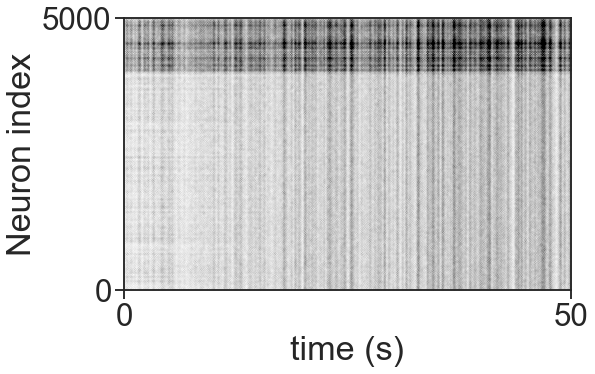

In [266]:
# s(0,:) are the spike times
# s(1,:) are the associated neuron indices

fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":2.3}) 

plt.scatter(s[0,:]/1000,s[1,:],s=0.000002,color='black')
plt.xlabel('time (s)')
plt.ylabel('Neuron index')
plt.ylim((0,N))
plt.yticks((0,N))
plt.xlim((0,T/1000/10))
plt.xticks((0,T/1000/10))

plt.show()

Time evolution of synaptic inputs. Balance is maintained.

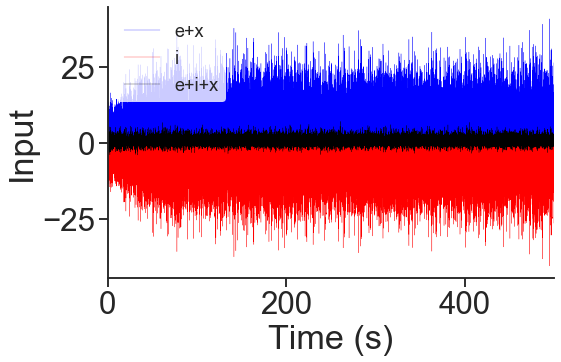

In [250]:
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)
# ax.spines['left'].set_color('black')
# ax.spines['left'].set_linewidth(3)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":0.3}) 

plt.plot(timeRecord/1000,np.mean(IeRec,axis=0)+np.mean(IxRec,axis=0),color='blue',label=r'e+x')

plt.plot(timeRecord/1000,np.mean(IiRec,axis=0),color='red',label=r'i')

plt.plot(timeRecord/1000,np.mean(IeRec,axis=0)+np.mean(IxRec,axis=0)+np.mean(IiRec,axis=0),color='black',label=r'e+i+x')

plt.xlabel('Time (s)')
plt.ylabel('Input')

plt.xlim((0,T/1000))

leg = plt.legend(loc='upper left',fontsize=18,frameon='none',markerscale=1)
leg.get_frame().set_linewidth(0.0)

sns.despine()

plt.show()


Time evolution of synaptic weights.

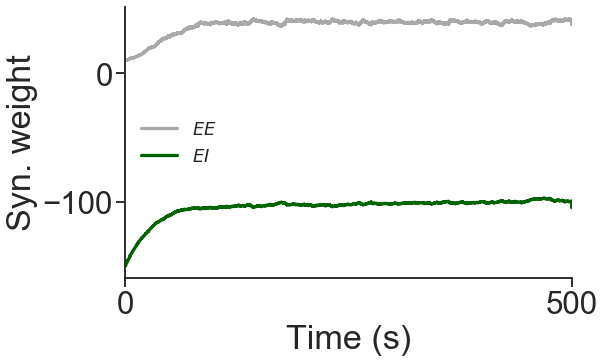

In [267]:
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)
# ax.spines['left'].set_color('black')
# ax.spines['left'].set_linewidth(3)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3}) 

if eta_ee_hebb !=0:
    plt.plot(timeRecord/1000,np.mean(JRec_ee,0),color='darkgrey',label=r'$EE$')
if eta_ee_koh !=0:
    plt.plot(timeRecord/1000,np.mean(JRec_ee,0),color='darkgrey',label=r'$EE$')
if eta_ie_hebb !=0:
    plt.plot(timeRecord/1000,np.mean(JRec_ie,0),color='pink',label=r'$IE$')
if eta_ie_homeo !=0:
    plt.plot(timeRecord/1000,np.mean(JRec_ie,0),color='pink',label=r'$IE$')
if eta_ei !=0:
    plt.plot(timeRecord/1000,np.mean(JRec_ei,0),color='darkgreen',label=r'$EI$')
if eta_ii !=0:
    plt.plot(timeRecord/1000,np.mean(JRec_ii,0),color='darkviolet',label=r'$II$')


plt.xlabel('Time (s)')
plt.ylabel('Syn. weight')

leg = plt.legend(loc='center left',fontsize=18,frameon='none',markerscale=1)
leg.get_frame().set_linewidth(0.0)

plt.xticks((0,T/1000))
plt.xlim((0,T/1000))
# plt.yticks((-150,-100,-50))
# plt.ylim((-150,-50))

sns.despine()

plt.show()


Distribution of each synaptic weight type.

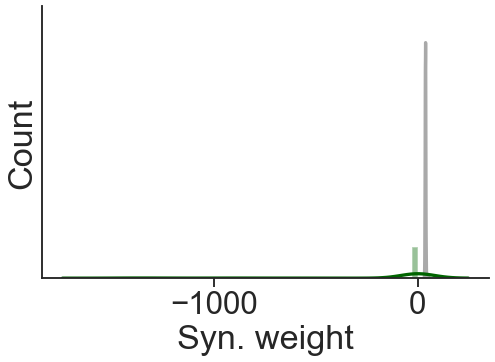

In [289]:
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3})


if eta_ee_hebb !=0:
    sns.distplot(JRec_ee[:,-1],color='darkgrey',rug=False, kde=True,bins = 100)
if eta_ee_koh !=0:
    sns.distplot(JRec_ee[:,-1],color='darkgrey',rug=False, kde=True,bins = 50)
if eta_ie_hebb !=0:
    sns.distplot(JRec_ie[:,-1],color='pink',rug=False, kde=True,bins = 100)
if eta_ie_homeo !=0:
    sns.distplot(JRec_ie[:,-1],color='pink',rug=False, kde=True,bins = 100)
if eta_ei !=0:
    sns.distplot(JRec_ei[:,-1],color='darkgreen',rug=False, kde=True,bins = 50)
if eta_ii !=0:
    sns.distplot(JRec_ii[:,-1],color='darkviolet',rug=False, kde=True,bins = 50)


# plt.axvline(x=0, color='black')

# Plot time-dependent rates
# plt.plot((dtRate:dtRate:T)/1000,1000*eRateT)
# plt.plot((dtRate:dtRate:T)/1000,1000*iRateT)
plt.xlabel('Syn. weight')
plt.ylabel('Count')
plt.yticks(())
# plt.xticks((-200,-100,0,100))
# plt.xlim((0,15))

sns.despine()

plt.show()

Time dependent firing rates averaged over each subpopulation E and I.

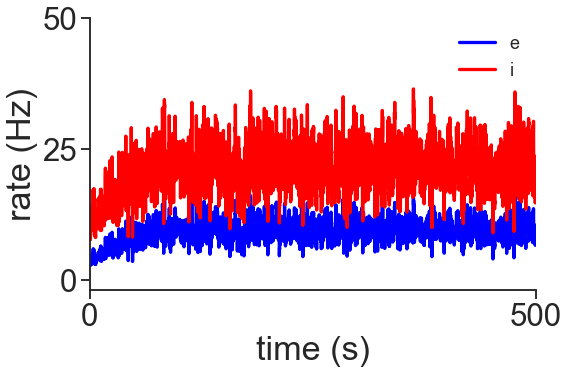

In [255]:
# Time-dependent mean rates
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3}) 

dtRate=100  # ms
timeVector = np.arange(dtRate,T+dtRate,dtRate) /1000 -25
hist, bin_edges = np.histogram(s[0,s[1,:]<Ne]
                  ,bins = len(timeVector)) 

eRateT = hist / (dtRate*Ne) *1000

hist, bin_edges = np.histogram(s[0,s[1,:]>=Ne]
                  ,bins = len(timeVector)) 
iRateT = hist / (dtRate*Ni) *1000

# Slide a window over the rates to smooth them.

window = 5
Num_points = np.int(len(eRateT) - window)

eRate_New = np.zeros((Num_points,1))
iRate_New = np.zeros((Num_points,1))

for i in range(Num_points):
    eRate_New[i,0] = np.mean(eRateT[i:i+window])
    iRate_New[i,0] = np.mean(iRateT[i:i+window])

burnTime = 0

# Plot time-dependent rates
plt.plot(np.linspace(0,T/1000,num=Num_points),eRate_New,color='blue',label=r'e')
plt.plot(np.linspace(0,T/1000,num=Num_points),iRate_New,color='red',label=r'i')
# plt.plot((dtRate:dtRate:T)/1000,1000*iRateT)
plt.ylabel('rate (Hz)')
plt.xlabel('time (s)')

plt.xticks((0,T/1000))
plt.xlim((0,T/1000))
plt.yticks((0,25,50))
plt.ylim((-2,50))

sns.despine()


leg = plt.legend(loc='upper right',fontsize=18,frameon='none',markerscale=1)
leg.get_frame().set_linewidth(0.0)


plt.show()

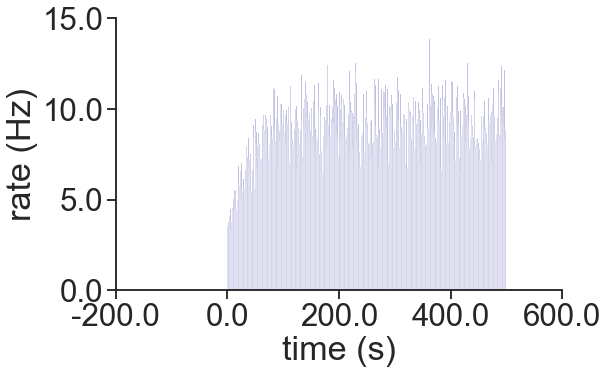

In [261]:
# Histogram of E rates.
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3}) 

dtRate=1000  # ms
fig = sns.distplot(s[0,s[1,:]<Ne],rug=False, kde=False,color='darkblue'
                  ,bins = len(np.arange(dtRate,T+dtRate,dtRate))) 
plt.yticks(fig.get_yticks(), 
           fig.get_yticks() / (dtRate*Ne) *1000 )
plt.xticks(fig.get_xticks(), 
           fig.get_xticks() / 1000 )

plt.ylabel('rate (Hz)')
plt.xlabel('time (s)')

# plt.xlim((0,T/1000))


sns.despine()

plt.show()

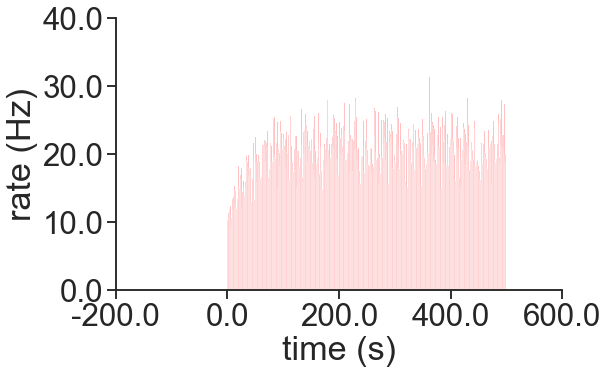

In [262]:
# Histogram of I rates
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3}) 

dtRate=1000 # ms
fig = sns.distplot(s[0,s[1,:]>=Ne], color='red',kde=False
                  ,bins = len(np.arange(dtRate,T+dtRate,dtRate))) 
plt.yticks(fig.get_yticks(), 
           fig.get_yticks() / (dtRate*Ni) *1000 )
plt.xticks(fig.get_xticks(), 
           fig.get_xticks() / 1000 )

plt.ylabel('rate (Hz)')
plt.xlabel('time (s)')

sns.despine()

plt.show()

Define a function to compute the full spike count covariance matrix. And another function to convert it to a spike count correlation matrix.

In [258]:
#  Compute spike count covariance matrix.
#  s is a 2x(ns) matrix where ns is the number of spikes
#  s(0,:) lists spike times
#  and s(1,:) lists corresponding neuron indices
#  Neuron indices are assumed to go from 1 to N

#  Spikes are counts starting at time T1 and ending at 
#  time T2.

#  winsize is the window size over which spikes are counted,
#  so winsize is assumed to be much smaller than T2-T1

#  Covariances are only computed between neurons whose
#  indices are listed in the vector Inds. If Inds is not
#  passed in then all NxN covariances are computed.

def SpikeCountCov(s,N,T1,T2,winsize):
 
    Inds=np.arange(0,N)

#   Count only spikes between T1, T2
    s1=s[:,(s[0,:]<=T2) & (s[1,:]>=T1)]

#   Count only for neurons between 0, N
    s1=s[:,(s[1,:]<N) & (s[1,:]>=0)]

#   Edges for histogram
    edgest=np.arange(T1,T2, winsize)
    edgesi=np.arange(0,N+1)

#   Get 2D histogram of spike indices and times
    counts, xedges, yedges = np.histogram2d(s1[0,:], 
                                            s1[1,:],
                                            bins=(edgest, edgesi))

#   Compute and return covariance matrix
    return np.array(np.cov(counts.transpose()))

def cov2corr(cov):
    '''convert covariance matrix to correlation matrix

    Parameters
    ----------
    cov : array_like, 2d
        covariance matrix, see Notes

    Returns
    -------
    corr : ndarray (subclass)
        correlation matrix
    return_std : bool
        If this is true then the standard deviation is also returned.
        By default only the correlation matrix is returned.

    Notes
    -----
    This function does not convert subclasses of ndarrays. This requires
    that division is defined elementwise. np.ma.array and np.matrix are allowed.

    '''
    cov = np.asanyarray(cov)
    std_ = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std_, std_)
    return corr

Use the functions defined above to compute the spike count correlation matrix.

In [259]:
## All the code below computes spike count covariances and correlations

# Compute spike count covariances over windows of size
# winsize starting at time T1 and ending at time T2.
winsize=250 # ms
T1=T/2 # ms
T2=T # ms
# Do computation
C=SpikeCountCov(s,N,T1,T2,winsize)


# Get mean spike count covariances over each sub-pop
II,JJ=np.meshgrid(np.arange(0,N),np.arange(0,N))
mCee=np.nanmean(C[(II<Ne) & (JJ<II)])
mCei=np.nanmean(C[(II<Ne) & (JJ>=Ne)])
mCii=np.nanmean(C[(II>Ne) & (JJ>II)])

# Mean-field spike count cov matrix
# Compare this to the theoretical prediction
mC=[[mCee, mCei], [mCei, mCii]]

# Compute spike count correlations
# This takes a while, so make it optional
ComputeSpikeCountCorrs=1
if(ComputeSpikeCountCorrs):
    
#    Get correlation matrix from cov matrix
    start_time = time.time()
    R=cov2corr(C)
    elapsed_time = time.time()-start_time
    print(elapsed_time/60, 'minutes')

    mRee=np.nanmean(R[(II<Ne) & (JJ<II)])
    mRei=np.nanmean(R[(II<Ne) & (JJ>=Ne)])
    mRii=np.nanmean(R[(II>Ne) & (JJ>II)])

    # Mean-field spike count correlation matrix
    mR=[[mRee, mRei], [mRei, mRii]]
    print('mR =',mR)

0.004343553384145101 minutes
mR = [[0.16692557079169643, 0.13536722640405463], [0.13536722640405463, 0.10988978746391397]]


Plot the distribution of spike count correlations.

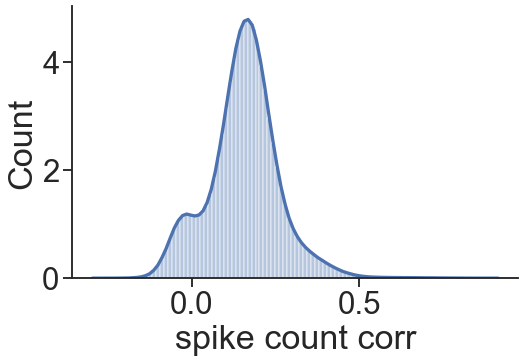

In [260]:
# Start the figure.
fig=plt.figure(figsize=(8,5))
ax = plt.subplot(111)

sns.set()
sns.set_style('whitegrid')
sns.set_style('white')
sns.set_style("ticks")
sns.set_context("talk", font_scale=1.9, rc={"lines.linewidth":3.3}) 

sns.distplot(R[(II<N) & (JJ<II)],bins=100)

plt.xlabel('spike count corr')
plt.ylabel('Count')

sns.despine()

plt.show()